# Problém batohu
Základ problému
Je dáno

- celé číslo `n` (počet věcí)
- celé číslo `M` (kapacita batohu)
- konečná množina `V = {v1, v2, ... ,vn }` (hmotnosti věcí)
- konečná množina `C = {c1, c2, ... ,cn }` (ceny věcí)

In [1]:
import numpy as np

In [29]:
instanceNList = [4, 10, 15, 20, 22, 25] # ... 27, 30, 32, 35, 37, 40
instanceSet = set()

### Implementace problému batohu 

In [3]:
import enum
from time import time

class Method(enum.Enum):
    """Enumerates types of methods"""
    BAB = 2   # Branch and Bound method
    G = 3     # Greedy method
    R = 4     # Redux method
    DHBP = 5  # Dynamic Heuristics By Price method


def timer(func):
    def wrap_func(*args, **kwargs):
        t1 = time()
        result = func(*args, **kwargs)
        t2 = time()
        print(f'Function {func.__name__!r} executed in {(t2-t1):.4f}s')
        return result
    return wrap_func

def quietTimer(func):
    def wrapFunc(*args, **kwargs):
        t1 = time()
        result = func(*args, **kwargs)
        t2 = time()
        
        # set 'self.executionTime' to measured time
        args[0].executionTime = t2-t1

        return result
    return wrapFunc

Definice Třídy Knapsack řešící problém a uchovávající výsledek

In [4]:
import math
import copy

class Knapsack:
    def __init__(self, initString):
        arr = initString.split()
        decisionProblem = int(arr[0]) < 0
        items = arr[4:] if decisionProblem else arr[3:]
        
        self.id = int(arr[0])
        self.n = int(arr[1])
        self.M = int(arr[2])
        self.B = int(arr[3]) if decisionProblem else None
        self.weights = list(map(lambda x: int(x), items[::2]))
        self.prices = list(map(lambda x: int(x), items[1::2]))
        self.solution = None
        self.solutionPrice = None
        self.decisionSolution = None
        self.initString = initString
        self.outputString = None
        self.stepsToSolve = None
        self.executionTime = None
        
    def __str__ (self):
        res = "KNAPSACK " + str(self.id) + "\n"
        res += "-----------------------------------" + "\n"
        res += "n = " + str(self.n) + "\tM = " + str(self.M) + "\tB = " + (str(self.B) if self.B else "--") + "\n"
        
        for (i, x) in enumerate(self.weights):
            res += "#" + str(i) + "\t" + str(x) + "\t" + str(self.prices[i]) + "\t\t" + (str(self.solution[i]) if self.solution is not None else "") + "\n"
        res += "-----------------------------------" + "\n"
        res += "CONSTRUCTIVE PROBLEM SOLUTION:\t" + (str(self.solutionPrice) if self.solutionPrice is not None else "--") + "\n"
        res += "DECISION PROBLEM SOLUTIONS:\t#" + (str(len(self.decisionSolution)) if self.decisionSolution is not None else "--") + "\n"
        res += "-----------------------------------" + "\n"
        
        return res
    
    def createOutputString(self):
        self.outputString = str(abs(self.id)) + " " + str(self.n) + " " + str(self.solutionPrice)
        if self.solution is None:
            return
        if len(self.solution) == 0:
            self.solution = [0] * self.n
        for s in self.solution:
            self.outputString += " " + str(s)    
    
    def __repr__ (self):
        self.createOutputString()
        return self.outputString if self.outputString is not None else "--"
    
    def getSolution(self):
        return self.__repr__()
    
    def getStepsToSolve(self):
        return self.stepsToSolve
    
    def getItemsInfo(self, arr):
        finalWeight = 0
        finalPrice = 0
        
        for (i, inKnapsack) in enumerate(arr):
            finalWeight += self.weights[i] if inKnapsack else 0
            finalPrice += self.prices[i] if inKnapsack else 0
            
        return (finalWeight, finalPrice)
    
    def getB(self):
        return self.B
    
    def solutionIsEmpty(self):
        return len(self.decisionSolution) == 0
    
    def getConstructiveSolution(self):
        return self.solutionPrice
    
    def getExecutionTime(self):
        return self.executionTime
    
    ######################
    # BRUTE FORCE
    ######################
    
    # Brute Force for constructive 0/1 problem
    def bruteForceAux(self, W, wt, val, n):
        # Base Case
        if n == 0 or W == 0:
            return (0, [])

        if (wt[n-1] > W):
            x = self.bruteForceAux(W, wt, val, n-1)
            path = x[1]
            path.append(0)
            return (x[0], path)

        else:
            x = self.bruteForceAux(W-wt[n-1], wt, val, n-1)
            y = self.bruteForceAux(W, wt, val, n-1)
            if x[0] + val[n-1] > y[0]:
                path = x[1]
                path.append(1)
                return (x[0] + val[n-1], path)
            else:
                path = y[1]
                path.append(0)
                return (y[0], path)
    
    def bruteForceSolve(self):
        x =  self.bruteForceAux(self.M, self.weights, self.prices, self.n)
        self.solution = x[1]
        self.solutionPrice = x[0]
        self.createOutputString()
        return x
    
    # Brute Force for decision 0/1 problem
    def decisionBruteForceSolve(self):
        self.solutionPrice = 0
        self.decisionSolution = []
        self.stepsToSolve = 2**self.n
        for i in range(2**self.n):
            x = ("{0:0" + str(self.n) + "b}").format(i)
            finalPrice = 0
            finalWeight = 0
            for (j, b) in enumerate(x):
                if int(b):
                    finalPrice += int(self.prices[j])
                    finalWeight += int(self.weights[j])
            if finalWeight <= self.M:
                if finalPrice > self.solutionPrice:
                    self.solutionPrice = finalPrice
                    self.solution = list(x)
                if finalPrice >= self.B:
                    self.decisionSolution.append(list(x))
        # no solution found
        if self.solution is None:
            self.solution = []
        
        self.createOutputString()
        return self.decisionSolution
    
    ######################
    # BRANCH AND BOUND
    ######################

    def returnSecondEl(self, e):
        return e[1]
        
    def babAux(self, n, M, accPrice, weights, prices, acc):
        # stop conditions
        if n == 0:
            self.stepsToSolve += 1
            if M >= 0 and accPrice > self.solutionPrice:
                self.solutionPrice = accPrice
            return
        
        # following subtree won't satisfy price boundary 
        if accPrice + sum(prices) < self.solutionPrice:
            return
        
        # item doesn't fit into knapsack - weight boundary
        if (weights[n-1] > M):
            self.babAux(n - 1, M, accPrice, weights[:n - 1], prices[:n - 1], acc + [0])
            return
        
        # item fits in knapsack
        else:
            # item fits and is added into knapsack
            self.babAux(n - 1, M - weights[n - 1], accPrice + prices[n - 1], weights[:n - 1], prices[:n - 1], acc + [1])
            # item fits but isn't added into knapsack
            self.babAux(n - 1, M, accPrice, weights[:n - 1], prices[:n - 1], acc + [0])

    @quietTimer    
    def bab(self):
        self.solutionPrice = 0
        self.decisionSolution = []
        self.stepsToSolve = 0
        
        self.babAux(self.n, self.M, 0, self.weights, self.prices, [])
        
        return self.solutionPrice
        
    ######################
    # GREEDY HEURISTICS
    ######################
    
    @quietTimer
    def greedy(self):
        elements = []
        M = self.M
        
        for (i, x) in enumerate(self.prices):
            d = {
                'i': i,
                'p': x,
                'w': self.weights[i],
                'r': x / self.weights[i],
                's': 0
            }
            elements.append(d)
        
        elements.sort(key=lambda x: x['r'], reverse=True)
        
#         print(elements)
        
        self.stepsToSolve = len(elements)
        solution = 0
        for (i, x) in enumerate(elements):
            # if fits to knapsack, add it in
            if x['w'] <= M:
                x['s'] = 1
                M -= x['w']
                solution += x['p']
                
        elements.sort(key=lambda x: x['i'])
#         solutionList = list(map(lambda x: x["s"], elements))
        self.solutionPrice = solution
                
        return solution
            
    ######################
    # REDUX HEURISITICS
    ######################
    
    @quietTimer
    def redux(self):
        greedyPrice = self.greedy()
        
        # find highest price than fits into knapsack
        highestPrice = 0
        for (i, x) in enumerate(self.prices):
            # if fits into Knapsack and is maximum so far
            if self.weights[i] <= self.M and x > highestPrice:
                highestPrice = x
        
        self.solutionPrice = max(greedyPrice, highestPrice)
        
        return self.solutionPrice
    
    ######################
    # DYNAMIC HEURISITICS BY PRICE
    ######################
    
    def dhbpIsInTable(self, i, c):
        return (True if c in self.dhbpTable[i].keys() else False)
    
    def dhbpAux(self, i, c):
        self.stepsToSolve += 1
        
        # check if already in table
        if self.dhbpIsInTable(i, c):
            return self.dhbpTable[i][c]
        
        # trivial Case
        if i == 0 and c == 0:
            return 0
        
        # impossible case
        if i == 0:
            return np.inf
        
        # recursive definition
        minW = min(self.dhbpAux(i - 1, c), self.dhbpAux(i - 1, c - self.prices[i - 1]) + self.weights[i - 1])
        
        # store to table
        self.dhbpTable[i][c] = minW
        
        return minW
    
    @quietTimer
    def dhbp(self):
        self.stepsToSolve = 0
        
        # create empty table
        self.dhbpTable = dict()
        for i in range(self.n + 1):
            self.dhbpTable[i] = dict()
        
        totalSum = sum(self.prices)
        
        # get highest price lower than M
        for i in range(totalSum, 0, -1):
            res = self.dhbpAux(self.n, i)
            if res <= self.M:
#                 print("weight:", res, ", price:", i)
                self.solutionPrice = i
                return i
        
        self.solutionPrice = 0
        return 0
        
    ######################
    # FPTAS
    ######################
    
    @quietTimer
    def fptas(self, e):
        
        C = max(self.prices)
        K = C * e / self.n
        
        # it would slowed down the computation because it would increase all prices
        if K <= 1:
            self.solutionPrice = self.dhbp()
            return self.solutionPrice
        
        # create new prices
        ci = []
        originalPrices = copy.deepcopy(self.prices)
        for p in self.prices:
            ci.append(math.floor(p/K))
            
        self.prices = ci
        
        # do the computation with dhbp
        result = self.dhbp()
        
        # store original prices
        self.prices = originalPrices
        
        self.solutionPrice = math.floor(result * K)
        
        return math.floor(result * K)
        

### Generátor sad instancí

In [5]:
from enum import Enum

class ExpData(Enum):
    RESULT = "results",
    TIME = "time",
    FAULT = "fault"

def getInstPath(setName: str, n: int, solutionFile=False):
    return f"sets/{setName}/" + getInstName(setName, n, solutionFile)

def getInstName(setName: str, n: int, solutionFile=False):
    return setName + "_" + str(n) + ("_inst.dat" if not solutionFile else "_sol.dat")

def getExpInstPath(setName: str, method: Method, n: int, data: ExpData):
    return f"exp/{setName}/{method.name}/{data.name}/{str(n)}.txt"

def prepareExpDicts(setNames: [str], methods: [Method], datas: [ExpData]):
    # ./exp/<setName>/<method>/<data>/<n>.txt
    subprocess.run(["mkdir", "-p", "exp"])
    for sn in setNames:
        subprocess.run(["mkdir", "-p", "exp/" + sn])
        for m in methods:
            subprocess.run(["mkdir", "-p", "exp/" + sn + "/" + m.name])
            for d in datas:
                subprocess.run(["mkdir", "-p", "exp/" + sn + "/" + m.name + "/" + d.name])

In [25]:
import subprocess
import os.path

class SetGenerator:
    def __init__(self):
        self.setDirectoryName = "sets"
        subprocess.run(["mkdir", "-p", self.setDirectoryName])

    def createSetDir(self, name):
        subprocess.run(["mkdir", "-p", self.setDirectoryName + "/" + name])
        
    def createValidationData(self, instances):
        inst = instances.split("\n")[:-1]
        res = []
        for i in inst:
            k = Knapsack(i)
            k.bab()
            res.append(k.__repr__())
            
        return "\n".join(res)
        
    def createSet(self, setName:str, instNum:int, W:int, C:int, m:float=None, w:str=None, c:str=None, k:float=None, recreate=False ,addSet=True):
        # create new directory; add new set
        if addSet:
            instanceSet.add(setName)
        self.createSetDir(setName)
        
        # prepare arguments
        l = []
        if m is not None:
            l.append("-m")
            l.append(str(m))
        if w is not None:
            l.append("-w")
            l.append(w)
        if c is not None:
            l.append("-c")
            l.append(c)
        if k is not None:
            l.append("-k")
            l.append(str(k))
        
        # execute and save generated instances
        for n in instanceNList:
            fPath = getInstPath(setName, n)
            f = open(fPath, "w")
            subprocess.run(["./gen-1.2/gen/kg2", "-n", str(n), "-N", str(instNum), "-W", str(W), "-C", str(C), *l], stdout=f)
            
            f.close()
            f = open(fPath, "r")
            instances = f.read()
            f.close()

            f2Path = getInstPath(setName, n, True)
            if not os.path.exists(f2Path) or recreate:
                f2 = open(f2Path, "w")
                f2.write(self.createValidationData(instances))
                f2.close()

    def permutateSet(self, setToPermutate: str, newSetName: str, N:int=1):
        instanceSet.add(newSetName)
        self.createSetDir(newSetName)

        for n in instanceNList:
            fPath = getInstPath(newSetName, n)
            f = open(fPath, "w")
            f2 = open(getInstPath(setToPermutate,n), "r")
            subprocess.run(["./gen-1.2/gen/kg_perm", "-d", "0", "-N", str(N)], stdin=f2, stdout=f)
            f.close()

            f = open(fPath, "r")
            lines = f.read()
            f.close()
            lines = lines.split("\n")
            newlines = []
            for (i, l) in enumerate(lines):
                d = l.split(' ')
                if i + 1 != len(lines):
                    d[0] = str(i + 1)
                newlines.append(' '.join(d))
            f = open(fPath, "w")
            f.write("\n".join(newlines))
            f.close()

            f3 = open(getInstPath(setToPermutate, n, True), "r")
            f4 = open(getInstPath(newSetName, n, True), "w")
            lines = [f3.read()]*N
            newlines = []
            for (i, l) in enumerate(lines):
                d = l.split(' ')
                d[0] = str(i + 1)
                newlines.append(' '.join(d))
            f4.write("\n".join(newlines))
            f3.close()
            f4.close()

    def detailExMaxWeight(self, recreate=False):
        self.createSet("D_W1", 100, 100, 500, recreate=recreate)
        self.createSet("D_W2", 100, 200, 500, recreate=recreate)
        self.createSet("D_W3", 100, 500, 500, recreate=recreate)
        self.createSet("D_W4", 100, 800, 500, recreate=recreate)
        self.createSet("D_W5", 100, 1200, 500, recreate=recreate)

    def detailExMaxPrice(self, recreate=False):
        self.createSet("D_P1", 100, 500, 100, recreate=recreate)
        self.createSet("D_P2", 100, 500, 200, recreate=recreate)
        self.createSet("D_P3", 100, 500, 500, recreate=recreate)
        self.createSet("D_P4", 100, 500, 800, recreate=recreate)
        self.createSet("D_P5", 100, 500, 1200, recreate=recreate)

    def detailExCorelation(self, recreate=False):
        self.createSet("D_C1", 100, 500, 500, c="uni", m=0.1, recreate=recreate)
        self.createSet("D_C2", 100, 500, 500, c="uni", m=0.5, recreate=recreate)
        self.createSet("D_C3", 100, 500, 500, c="uni", m=1, recreate=recreate)
        self.createSet("D_C4", 100, 500, 500, c="uni", m=1.5, recreate=recreate)
        self.createSet("D_C5", 100, 500, 500, c="uni", m=2, recreate=recreate)

        self.createSet("D_D1", 100, 500, 500, c="corr", m=0.1, recreate=recreate)
        self.createSet("D_D2", 100, 500, 500, c="corr", m=0.5, recreate=recreate)
        self.createSet("D_D3", 100, 500, 500, c="corr", m=1, recreate=recreate)
        self.createSet("D_D4", 100, 500, 500, c="corr", m=1.5, recreate=recreate)
        self.createSet("D_D5", 100, 500, 500, c="corr", m=2, recreate=recreate)

        self.createSet("D_E1", 100, 500, 500, c="strong", m=0.1, recreate=recreate)
        self.createSet("D_E2", 100, 500, 500, c="strong", m=0.5, recreate=recreate)
        self.createSet("D_E3", 100, 500, 500, c="strong", m=1, recreate=recreate)
        self.createSet("D_E4", 100, 500, 500, c="strong", m=1.5, recreate=recreate)
        self.createSet("D_E5", 100, 500, 500, c="strong", m=2, recreate=recreate)

    def detailExGranularity(self, recreate=False):
        self.createSet("D_G1", 100, 500, 500, w="light", k=0.2, recreate=recreate)
        self.createSet("D_G2", 100, 500, 500, w="light", k=0.5, recreate=recreate)
        self.createSet("D_G3", 100, 500, 500, w="light", k=1, recreate=recreate)
        self.createSet("D_G4", 100, 500, 500, w="light", k=1.5, recreate=recreate)
        self.createSet("D_G5", 100, 500, 500, w="light", k=2, recreate=recreate)

        self.createSet("D_H1", 100, 500, 500, w="heavy", k=0.2, recreate=recreate)
        self.createSet("D_H2", 100, 500, 500, w="heavy", k=0.5, recreate=recreate)
        self.createSet("D_H3", 100, 500, 500, w="heavy", k=1, recreate=recreate)
        self.createSet("D_H4", 100, 500, 500, w="heavy", k=1.5, recreate=recreate)
        self.createSet("D_H5", 100, 500, 500, w="heavy", k=2, recreate=recreate)

        self.createSet("D_I1", 100, 500, 500, w="bal", recreate=recreate)
        self.createSet("D_I2", 100, 500, 500, w="bal", recreate=recreate)
        self.createSet("D_I3", 100, 500, 500, w="bal", recreate=recreate)
        self.createSet("D_I4", 100, 500, 500, w="bal", recreate=recreate)
        self.createSet("D_I5", 100, 500, 500, w="bal", recreate=recreate)

    def detailExRobustness(self, recreate=False):
        self.createSet("D_M1", 100, 500, 500, recreate=recreate)
        self.permutateSet("D_M1", "D_M2")
        self.permutateSet("D_M2", "D_M3")
        self.permutateSet("D_M3", "D_M4")
        self.permutateSet("D_M4", "D_M5")

    def detailExRobustness2(self, recreate=False):
        self.createSet("D_X1", 1, 500, 500, recreate=recreate, addSet=False)
        self.permutateSet("D_X1", "D_Y1", 100)
        self.createSet("D_X2", 1, 500, 500, recreate=recreate, addSet=False)
        self.permutateSet("D_X2", "D_Y2", 100)
        self.createSet("D_X3", 1, 500, 500, recreate=recreate, addSet=False)
        self.permutateSet("D_X3", "D_Y3", 100)
        self.createSet("D_X4", 1, 500, 500, recreate=recreate, addSet=False)
        self.permutateSet("D_X4", "D_Y4", 100)
        self.createSet("D_X5", 1, 500, 500, recreate=recreate, addSet=False)
        self.permutateSet("D_X5", "D_Y5", 100)
        self.createSet("D_X6", 1, 500, 500, recreate=recreate, addSet=False)
        self.permutateSet("D_X6", "D_Y6", 100)
        self.createSet("D_X7", 1, 500, 500, recreate=recreate, addSet=False)
        self.permutateSet("D_X7", "D_Y7", 100)
        self.createSet("D_X8", 1, 500, 500, recreate=recreate, addSet=False)
        self.permutateSet("D_X8", "D_Y8", 100)
        self.createSet("D_X9", 1, 500, 500, recreate=recreate, addSet=False)
        self.permutateSet("D_X9", "D_Y9", 100)
        self.createSet("D_X10", 1, 500, 500, recreate=recreate, addSet=False)
        self.permutateSet("D_X10", "D_Y10", 100)



In [30]:
sg = SetGenerator()
sg.detailExMaxWeight()
sg.detailExMaxPrice()
sg.detailExCorelation()
sg.detailExGranularity()
sg.detailExRobustness()
sg.detailExRobustness2()

## Manager of Sets

In [9]:
class SetComputer:
    def retrieveInstances(self, filename):
        f = open(filename, "r")
        fileString = f.read()
        lines = fileString.split('\n')
        
        dictionary = dict()
        for l in lines:
            if l == '':
                continue
            lid = l.split(' ')[0]
            dictionary[lid] = {
                "instanceString": l,
                "resultString": None,
                "time": None,
                "error": None
            }

        return dictionary

    def computeInstance(self, instanceString, method):
        print(instanceString)
        inst = Knapsack(instanceString)

        # solve instance with chosen method
        if method == Method.BAB:
            inst.bab()
        elif method == Method.G:
            inst.greedy()
        elif method == Method.R:
            inst.redux()
        elif method == Method.DHBP:
            inst.dhbp()

        return inst.__repr__(), inst.getExecutionTime()

    def writeToFile(self, fileName, contentString):
        f = open(fileName, "w")
        f.write(contentString)
        f.close()

    def calculateFault(self, resultString: str, correctResString: str):
        res = float(resultString.split(' ')[2])
        correct = float(correctResString.split(' ')[2])
        fault = abs(res) if correct == 0 else (correct - res) / correct
        return str(fault)

    def computeFile(self, filename, method, outputFile, timeFile, faultFile, solutionFile):
        dictionary = self.retrieveInstances(filename)
        correctDict = self.retrieveInstances(solutionFile)

        resultStrings = []
        times = []
        faults = []
        for iid in dictionary.keys():
            resultString, executionTime = self.computeInstance(dictionary[iid]["instanceString"], method)
            resultStrings.append(resultString)
            times.append(str(executionTime))
            faults.append(self.calculateFault(resultString, correctDict[iid]["instanceString"]))

        self.writeToFile(outputFile, "\n".join(resultStrings))
        self.writeToFile(timeFile, "\n".join(times))
        self.writeToFile(faultFile, "\n".join(faults))

    def computeSets(self, setName):
        for m in Method:
            for n in instanceNList:
                self.computeFile(
                    getInstPath(setName, n),
                    m,
                    getExpInstPath(setName, m, n, ExpData.RESULT),
                    getExpInstPath(setName, m, n, ExpData.TIME),
                    getExpInstPath(setName, m, n, ExpData.FAULT),
                    getInstPath(setName, n, True)
                )
    def compute(self, sets=instanceSet):
        # create directories for files
        prepareExpDicts(
            list(instanceSet),
            [e for e in Method],
            [e for e in ExpData]
        )

        # compute each set
        for sn in sets:
            self.computeSets(sn)


In [18]:
sc = SetComputer()
# sc.compute({'P_W0', 'P_W1', 'P_W2', 'P_W3', 'P_W4'})
# sc.compute({'P_P0', 'P_P1', 'P_P2', 'P_P3', 'P_P4'})
# sc.compute({'D_W1', 'D_W2', 'D_W3', 'D_W4', 'D_W5'})
# sc.compute({'D_P1', 'D_P2', 'D_P3', 'D_P4', 'D_P5'})
# sc.compute({'D_G1', 'D_G2', 'D_G3', 'D_G4', 'D_G5', 'D_H1', 'D_H2', 'D_H3', 'D_H4', 'D_H5'})
# sc.compute({'D_C1', 'D_C2', 'D_C3', 'D_C4', 'D_C5', 'D_D1', 'D_D2', 'D_D3', 'D_D4', 'D_D5', 'D_E1', 'D_E2', 'D_E3', 'D_E4', 'D_E5'})
# sc.compute({'D_I1', 'D_I2', 'D_I3', 'D_I4', 'D_I5'})
sc.compute({'D_Y1', 'D_Y2', 'D_Y3', 'D_Y4', 'D_Y5', 'D_Y6', 'D_Y7', 'D_Y8', 'D_Y9', 'D_Y10'})

1 4 688 72 1 86 226 404 19 298 417
2 4 688 86 226 298 417 404 19 72 1
3 4 688 404 19 72 1 86 226 298 417
4 4 688 72 1 404 19 86 226 298 417
5 4 688 86 226 404 19 298 417 72 1
6 4 688 86 226 404 19 72 1 298 417
7 4 688 298 417 72 1 404 19 86 226
8 4 688 86 226 298 417 72 1 404 19
9 4 688 404 19 72 1 298 417 86 226
10 4 688 404 19 72 1 86 226 298 417
11 4 688 86 226 404 19 298 417 72 1
12 4 688 404 19 72 1 298 417 86 226
13 4 688 72 1 298 417 404 19 86 226
14 4 688 298 417 404 19 72 1 86 226
15 4 688 86 226 298 417 404 19 72 1
16 4 688 298 417 72 1 404 19 86 226
17 4 688 404 19 86 226 72 1 298 417
18 4 688 86 226 404 19 72 1 298 417
19 4 688 298 417 86 226 72 1 404 19
20 4 688 72 1 298 417 86 226 404 19
21 4 688 72 1 86 226 404 19 298 417
22 4 688 404 19 298 417 72 1 86 226
23 4 688 86 226 298 417 404 19 72 1
24 4 688 72 1 298 417 404 19 86 226
25 4 688 298 417 404 19 86 226 72 1
26 4 688 298 417 72 1 404 19 86 226
27 4 688 298 417 72 1 86 226 404 19
28 4 688 72 1 298 417 404 19 86 226
2

## Analýza experimentů

In [47]:
import json
import statistics
import matplotlib.pyplot as plt
import numpy as np

class ExpAnalyzer:
    def __init__(self):
        self.results = dict()
        for instanceName in instanceSet:
            self.results[instanceName] = dict()
            for method in Method:
                self.results[instanceName][method.name] = dict()
                for feature in ExpData:
                    self.results[instanceName][method.name][feature.name] = dict()
                    for n in instanceNList:
                        try:
                            f = open(getExpInstPath(instanceName, method, n, feature), "r")
                            lines = f.readlines()
                            f.close()
                            self.results[instanceName][method.name][feature.name][n] = list(map(lambda x: float(x), lines))
                        except:
                            self.results[instanceName][method.name][feature.name][n] = None

    def computeStatistics(self):
        self.statistics = dict()
        for setKey in self.results.keys():
            self.statistics[setKey] = dict()
            for methodKey in self.results[setKey].keys():
                timeByN = [self.results[setKey][methodKey][ExpData.TIME.name][x] for x in instanceNList]
                faultByN = [self.results[setKey][methodKey][ExpData.FAULT.name][x] for x in instanceNList]

                self.statistics[setKey][methodKey] = dict()
                self.statistics[setKey][methodKey]["avgTime"] = [round(statistics.mean(t), 6) for t in timeByN]
                self.statistics[setKey][methodKey]["avgFault"] = [round(max(t), 6) for t in faultByN]
                self.statistics[setKey][methodKey]["maxFault"] = [round(max(t), 6) for t in faultByN]
                self.statistics[setKey][methodKey]["maxTime"] = [round(max(t), 6) for t in timeByN]
                self.statistics[setKey][methodKey]["minTime"] = [round(min(t), 6) for t in timeByN]

    def analyze(self):
        # compute statistics about mean time, mean steps and mean relative fault
        self.computeStatistics()
        print(self.statistics)

        with open('output.json', 'w+') as f:
            json.dump(self.statistics, f, indent=4)

        for method in Method:
            print(f"======= {method.name} =======")
            self.printAvgTimeWeightGraph(4, method)
            self.printAvgTimePriceGraph(4, method)
            self.printGranularity(4, method, False)
            self.printGranularity(4, method, True)
            self.printGranularityTime(4, method)
            self.printRatio(4, method, None)
            self.printRatio(4, method, False)
            self.printRatio(4, method, True)
            print("------ Chyby -------")
            self.printMaxPriceFault(4, method)
            self.printMaxWeightFault(4, method)
            self.printGranularityFault(4, method)
            self.printRatioFault(4, method)
            print("------ Robustnost -------")
            self.printRobustness(4, method)
            self.printRobustness2(4, method)

    def printAvgTimePriceGraph(self, n: int, method: Method):
        x = [100, 200, 500, 800, 1200]

        y = [self.statistics[x][method.name]["avgTime"][n]
             for x in ['D_P1', 'D_P2', 'D_P3', 'D_P4', 'D_P5']
             ]
        y1 = [self.statistics[x][method.name]["avgTime"][n + 1]
               for x in ['D_P1', 'D_P2', 'D_P3', 'D_P4', 'D_P5']
             ]
        y2 = [self.statistics[x][method.name]["avgTime"][n - 1]
              for x in ['D_P1', 'D_P2', 'D_P3', 'D_P4', 'D_P5']
              ]

        plt.scatter(x, y1, label=str(instanceNList[n+1]))
        plt.scatter(x, y, label=str(instanceNList[n]))
        plt.scatter(x, y2, label=str(instanceNList[n-1]))
        plt.xlabel("Maximální cena (C)")  # add X-axis label
        plt.ylabel("Průměrný čas (s)")  # add Y-axis label
        plt.title(f"Test omezení maximální ceny pro {method.name}")  # add title
        plt.legend(bbox_to_anchor=(1,1), loc="upper left", title="n")
        plt.show()

    def printAvgTimeWeightGraph(self, n: int, method: Method):
        x = [100, 200, 500, 800, 1200]
        y = [self.statistics[x][method.name]["avgTime"][n]
             for x in ['D_W1', 'D_W2', 'D_W3', 'D_W4', 'D_W5']
             ]
        y2 = [self.statistics[x][method.name]["avgTime"][n + 1]
             for x in ['D_W1', 'D_W2', 'D_W3', 'D_W4', 'D_W5']
             ]
        y3 = [self.statistics[x][method.name]["avgTime"][n - 1]
              for x in ['D_W1', 'D_W2', 'D_W3', 'D_W4', 'D_W5']
              ]

        plt.scatter(x, y2, label=str(instanceNList[n+1]))
        plt.scatter(x, y, label=str(instanceNList[n]))
        plt.scatter(x, y3, label=str(instanceNList[n-1]))
        plt.xlabel("Maximální váha (W)")  # add X-axis label
        plt.ylabel("Průměrný čas (s)")  # add Y-axis label
        plt.title(f"Test omezení maximální váhy pro {method.name}")  # add title
        plt.legend(bbox_to_anchor=(1,1), loc="upper left", title="n")
        plt.show()

    def printGranularity(self, n: int, method: Method, heavy: bool):
        x = [0.2, 0.5, 1, 1.5, 2]
        y = []

        listOfSet = ['D_H1', 'D_H2', 'D_H3', 'D_H4', 'D_H5'] if heavy else ['D_G1', 'D_G2', 'D_G3', 'D_G4', 'D_G5']
        for number in [n-1, n, n+1]:
            y.append(
                [self.statistics[x][method.name]["avgTime"][number]
                 for x in listOfSet
                 ]
            )

        plt.scatter(x, y[0], label=str(instanceNList[n-1]))
        plt.scatter(x, y[1], label=str(instanceNList[n]))
        plt.scatter(x, y[2], label=str(instanceNList[n+1]))
        plt.xlabel("Exponent granularity (k)")  # add X-axis label
        plt.ylabel("Průměrný čas (s)")  # add Y-axis label
        plt.title(f"Test granularity s převahou {'těžkých' if heavy else 'lehkých'} věcí v závislosti na k pro {method.name}")  # add title
        plt.legend(bbox_to_anchor=(1,1), loc="upper left", title="n")
        plt.show()

    def printRatio(self, n: int, method: Method, strongCor: bool):
        x = [0.1, 0.5, 1, 1.5, 2]
        y = []

        listOfSet = ['D_C1', 'D_C2', 'D_C3', 'D_C4', 'D_C5'] if strongCor is None else\
            (['D_D1', 'D_D2', 'D_D3', 'D_D4', 'D_D5'] if not strongCor else\
            ['D_E1', 'D_E2', 'D_E3', 'D_E4', 'D_E5'])
        for number in [n-1, n, n+1]:
            y.append(
                [self.statistics[x][method.name]["avgTime"][number]
                 for x in listOfSet
                 ]
            )

        plt.scatter(x, y[0], label=str(instanceNList[n-1]))
        plt.scatter(x, y[1], label=str(instanceNList[n]))
        plt.scatter(x, y[2], label=str(instanceNList[n+1]))
        plt.xlabel("Poměr kapacity batohu k sumární váze (m)")  # add X-axis label
        plt.ylabel("Průměrný čas (s)")  # add Y-axis label
        plt.title(f"Test poměru kapacity k sumární váze pro {method.name} - {'žádná' if strongCor is None else ('silná' if strongCor else 'mírná')} korelace")  # add title
        plt.legend(bbox_to_anchor=(1,1), loc="upper left", title="n")
        plt.show()

    def printScatter(self, n: int, x:[any], y: [[str]], xlabel: str, ylabel: str, title: str):
        plt.scatter(x, y[0], label=str(instanceNList[n-1]))
        plt.scatter(x, y[1], label=str(instanceNList[n]))
        plt.scatter(x, y[2], label=str(instanceNList[n+1]))
        plt.xlabel(xlabel)  # add X-axis label
        plt.ylabel(ylabel)  # add Y-axis label
        plt.title(title)  # add title
        plt.legend(bbox_to_anchor=(1,1), loc="upper left", title="n")
        plt.show()

    # ===== chyby =====

    def printMaxPriceFault(self, n: int, method: Method):
        x = [100, 200, 500, 800, 1200]
        y = []
        for number in [n-1, n, n+1]:
            y.append(
                [self.statistics[x][method.name]["avgFault"][number]
                 for x in ['D_P1', 'D_P2', 'D_P3', 'D_P4', 'D_P5']
                 ]
            )

        self.printScatter(n,
                          x,
                          y,
                          "Maximální cena (C)",
                          "Průměrná relativní chyba",
                          f"Test omezení maximální ceny pro {method.name}"
                          )

    def printMaxWeightFault(self, n: int, method: Method):
        x = [100, 200, 500, 800, 1200]
        y = []
        for number in [n-1, n, n+1]:
            y.append(
                [self.statistics[x][method.name]["avgFault"][number]
                 for x in ['D_W1', 'D_W2', 'D_W3', 'D_W4', 'D_W5']
                 ]
            )

        self.printScatter(n,
                          x,
                          y,
                          "Maximální váha (C)",
                          "Průměrná relativní chyba",
                          f"Test omezení maximální váhy pro {method.name}"
                          )
    def printGranularityTime(self, n: int, method: Method):
        x = [0.2, 0.5, 1, 1.5, 2]
        ybal = []
        yheavy = []
        ylight = []
        for number in [n-1, n, n+1]:
            yheavy.append(
                [self.statistics[x][method.name]["avgTime"][number]
                 for x in ['D_H1', 'D_H2', 'D_H3', 'D_H4', 'D_H5']
                 ]
            )
            ylight.append(
                [self.statistics[x][method.name]["avgTime"][number]
                 for x in ['D_G1', 'D_G2', 'D_G3', 'D_G4', 'D_G5']
                 ]
            )
            ybal.append(
                [self.statistics[x][method.name]["avgTime"][number]
                 for x in ['D_I1', 'D_I2', 'D_I3', 'D_I4', 'D_I5']
                 ]
            )

        self.printScatter(n, x, ylight, "Exponent granularity (k)", "Průměrná čas (s)", f"Test granularity s převahou lehkých věcí v závislosti na k pro {method.name}")
        self.printScatter(n, x, yheavy, "Exponent granularity (k)", "Průměrná čas (s)", f"Test granularity s převahou těžkých věcí v závislosti na k pro {method.name}")
        self.printScatter(n, [1, 2, 3, 4, 5], ybal, "Exponent granularity (k)", "Průměrná čas (s)", f"Test granularity s vybalancovanými lehkými a těžkými věcmi pro {method.name}")

    def printGranularityFault(self, n: int, method: Method):
        x = [0.2, 0.5, 1, 1.5, 2]
        yheavy = []
        ylight = []
        for number in [n-1, n, n+1]:
            yheavy.append(
                [self.statistics[x][method.name]["avgFault"][number]
                 for x in ['D_H1', 'D_H2', 'D_H3', 'D_H4', 'D_H5']
                 ]
            )
            ylight.append(
                [self.statistics[x][method.name]["avgFault"][number]
                 for x in ['D_G1', 'D_G2', 'D_G3', 'D_G4', 'D_G5']
                 ]
            )

        self.printScatter(n, x, ylight, "Exponent granularity (k)", "Průměrná relativní chyba", f"Test granularity s převahou lehkých věcí v závislosti na k pro {method.name}")
        self.printScatter(n, x, yheavy, "Exponent granularity (k)", "Průměrná relativní chyba", f"Test granularity s převahou těžkých věcí v závislosti na k pro {method.name}")

    def printRatioFault(self, n:int, method: Method):
        x = [0.1, 0.5, 1, 1.5, 2]
        ynone = []
        ycorr = []
        ystrong = []
        for number in [n-1, n, n+1]:
            ynone.append(
                [self.statistics[x][method.name]["avgFault"][number]
                 for x in ['D_C1', 'D_C2', 'D_C3', 'D_C4', 'D_C5']
                 ]
            )
            ycorr.append(
                [self.statistics[x][method.name]["avgFault"][number]
                 for x in ['D_D1', 'D_D2', 'D_D3', 'D_D4', 'D_D5']
                 ]
            )
            ystrong.append(
                [self.statistics[x][method.name]["avgFault"][number]
                 for x in ['D_E1', 'D_E2', 'D_E3', 'D_E4', 'D_E5']
                 ]
            )
        self.printScatter(n, x, ynone, "Poměr kapacity batohu k sumární váze (m)", "Průměrná relativní chyba", f"Test poměru kapacity k sumární váze pro {method.name} - žádná korelace")
        self.printScatter(n, x, ycorr, "Poměr kapacity batohu k sumární váze (m)", "Průměrná relativní chyba", f"Test poměru kapacity k sumární váze pro {method.name} - mírná korelace")
        self.printScatter(n, x, ystrong, "Poměr kapacity batohu k sumární váze (m)", "Průměrná relativní chyba", f"Test poměru kapacity k sumární váze pro {method.name} - silná korelace")

    # ----------- robustness -----------

    def printRobustness(self, n:int, method: Method):
        x = [1, 2, 3, 4, 5]
        yfault = []
        ytime = []
        for number in [n-1, n, n+1]:
            yfault.append(
                [self.statistics[x][method.name]["avgFault"][number]
                 for x in ['D_M1', 'D_M2', 'D_M3', 'D_M4', 'D_M5']
                 ]
            )
            ytime.append(
                [self.statistics[x][method.name]["avgTime"][number]
                 for x in ['D_M1', 'D_M2', 'D_M3', 'D_M4', 'D_M5']
                 ]
            )

        self.printScatter(n, x, yfault, "permutace", "Průměrná relativní chyba", f"Test robustnosti pro {method.name} - průměrná relativní chyba")
        self.printScatter(n, x, ytime, "permutace", "Průměrný čas (s)", f"Test robustnosti pro {method.name} - průměrný čas")

    def printRobustness2(self, param, method):
        x = [1,2,3,4,5,6,7,8,9,10]
        n = 4 # tedy n = 25
        y = [self.statistics[x][method.name]["avgTime"][n]
             for x in ['D_Y1', 'D_Y2', 'D_Y3', 'D_Y4', 'D_Y5', 'D_Y6', 'D_Y7', 'D_Y8', 'D_Y9', 'D_Y10']
             ]
        y2 = [self.statistics[x][method.name]["maxTime"][n]
             for x in ['D_Y1', 'D_Y2', 'D_Y3', 'D_Y4', 'D_Y5', 'D_Y6', 'D_Y7', 'D_Y8', 'D_Y9', 'D_Y10']
             ]
        y3 = [self.statistics[x][method.name]["minTime"][n]
             for x in ['D_Y1', 'D_Y2', 'D_Y3', 'D_Y4', 'D_Y5', 'D_Y6', 'D_Y7', 'D_Y8', 'D_Y9', 'D_Y10']
             ]
        plt.scatter(x, y, label="průměrná doba")
        plt.scatter(x, y2, label="maximální doba")
        plt.scatter(x, y3, label="minimální doba")
        plt.xlabel("Číslo instance")  # add X-axis label
        plt.ylabel("Čas vykonávání (s)")  # add Y-axis label
        plt.title(f"Test robustnosti pro {method.name}")  # add title
        plt.legend(bbox_to_anchor=(1,1), loc="upper left", title="n")
        plt.show()



{'D_Y9': {'BAB': {'avgTime': [1e-05, 4e-05, 0.000135, 0.000516, 0.000592, 0.001651], 'avgFault': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'maxFault': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'maxTime': [3.1e-05, 0.000109, 0.000548, 0.001976, 0.001901, 0.010858], 'minTime': [5e-06, 1.3e-05, 2.7e-05, 7e-05, 0.000146, 0.000243]}, 'G': {'avgTime': [6e-06, 1e-05, 1.5e-05, 1.8e-05, 2e-05, 2.3e-05], 'avgFault': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'maxFault': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'maxTime': [4.2e-05, 2.9e-05, 4.4e-05, 4.9e-05, 3.9e-05, 4.8e-05], 'minTime': [4e-06, 9e-06, 1.2e-05, 1.6e-05, 1.7e-05, 1.9e-05]}, 'R': {'avgTime': [7e-06, 1.3e-05, 1.6e-05, 2.2e-05, 2.7e-05, 2.7e-05], 'avgFault': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'maxFault': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'maxTime': [2.9e-05, 3.4e-05, 2.7e-05, 4.4e-05, 6.9e-05, 6.2e-05], 'minTime': [6e-06, 1.1e-05, 1.5e-05, 2e-05, 2.1e-05, 2.4e-05]}, 'DHBP': {'avgTime': [0.000294, 0.006992, 0.029951, 0.059021, 0.069043, 0.088923], 'avgFault': [0.0, 0.0, 0.0, 0.0

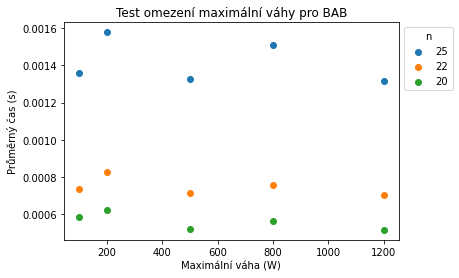

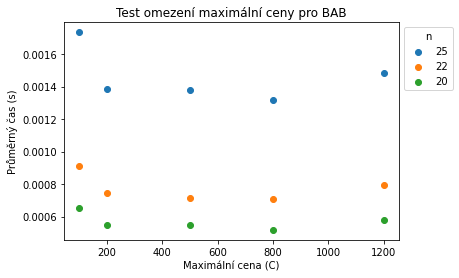

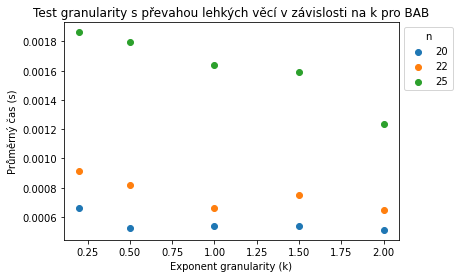

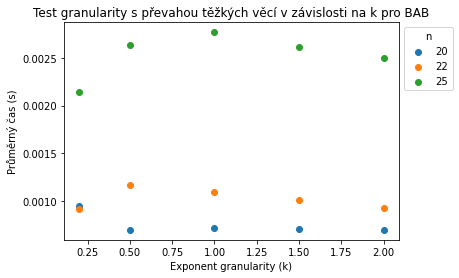

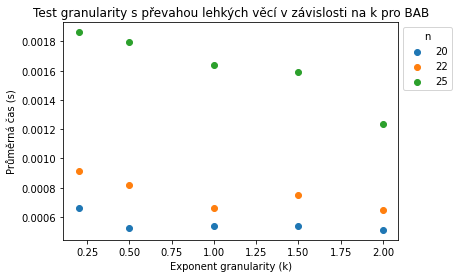

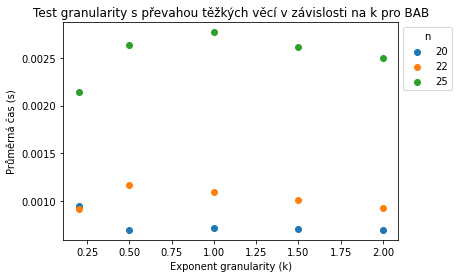

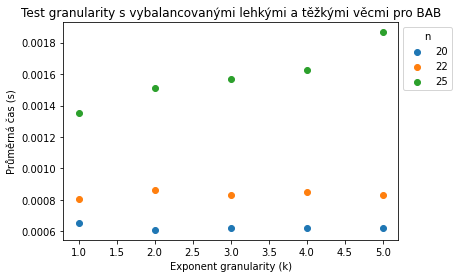

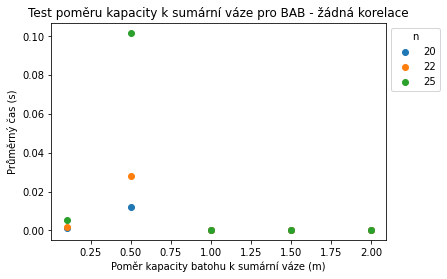

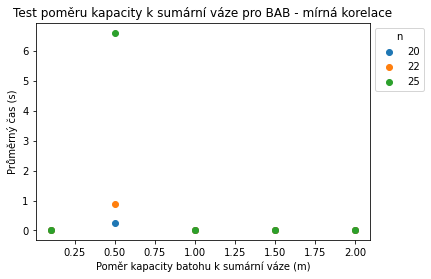

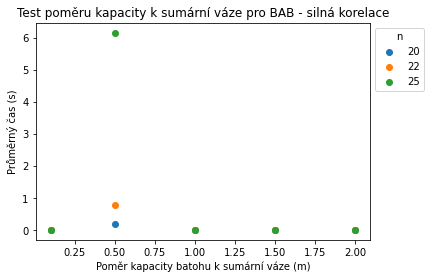

------ Chyby -------


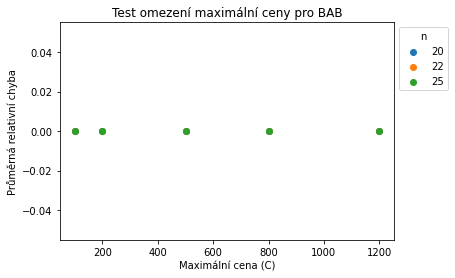

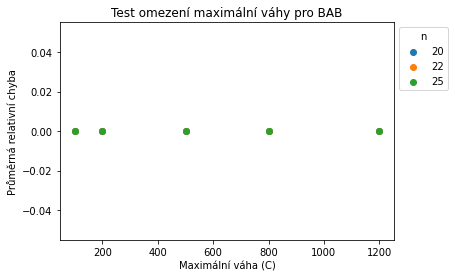

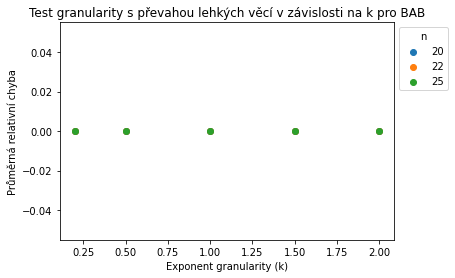

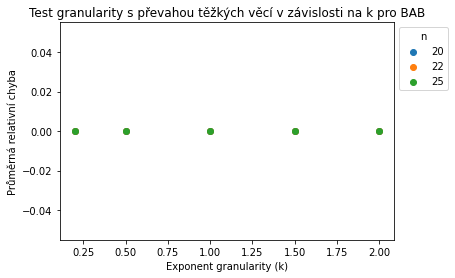

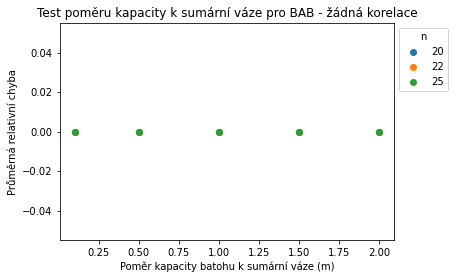

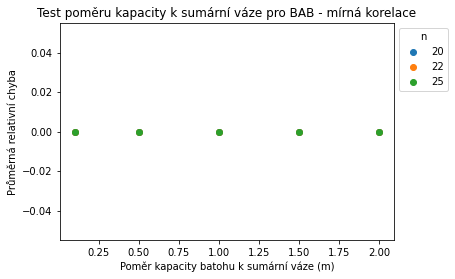

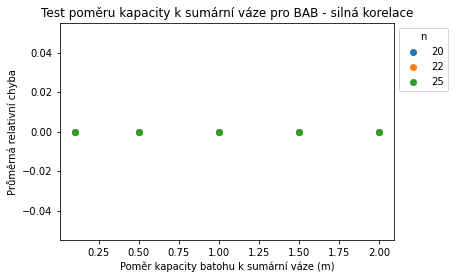

------ Robustnost -------


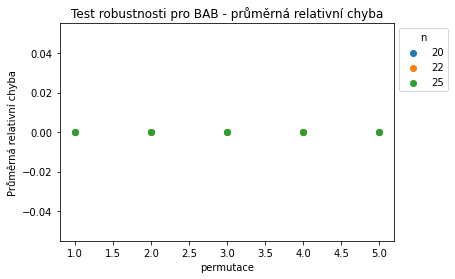

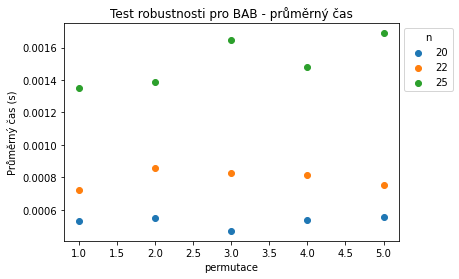

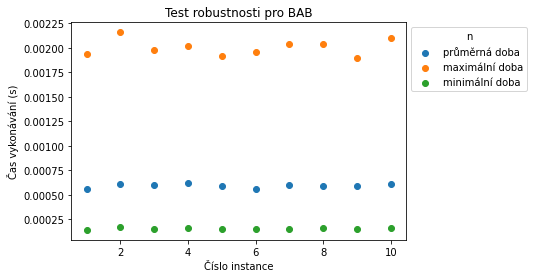

======= G =======


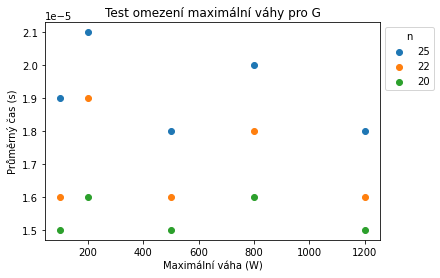

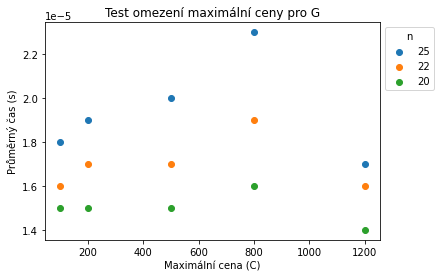

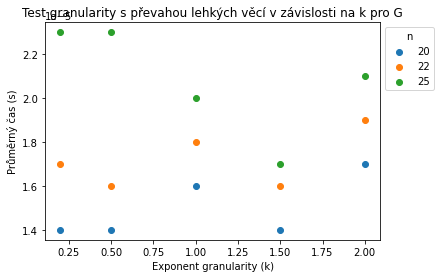

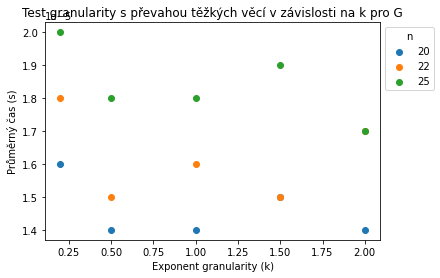

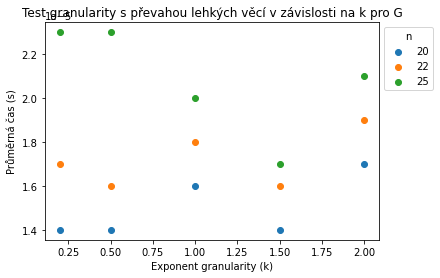

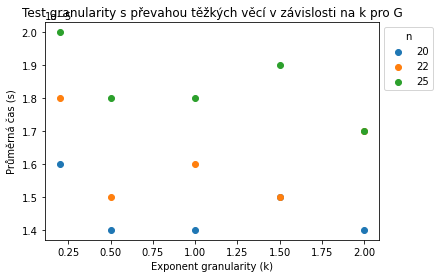

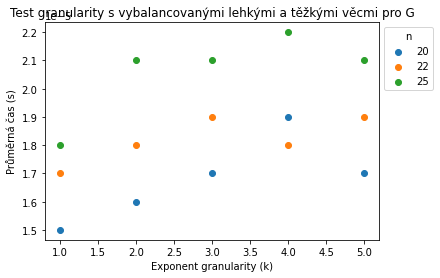

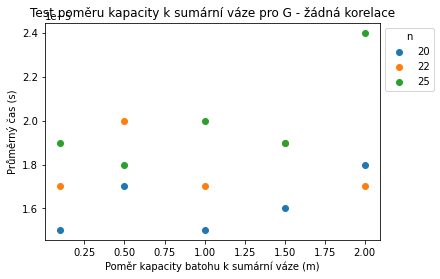

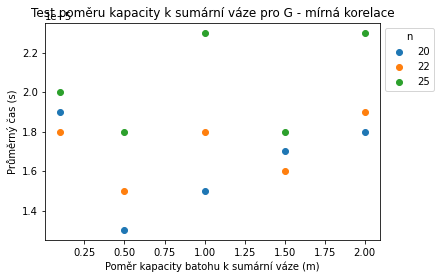

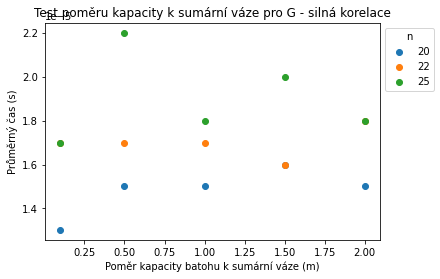

------ Chyby -------


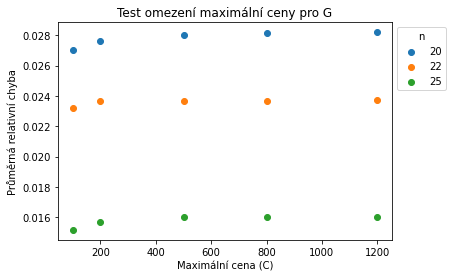

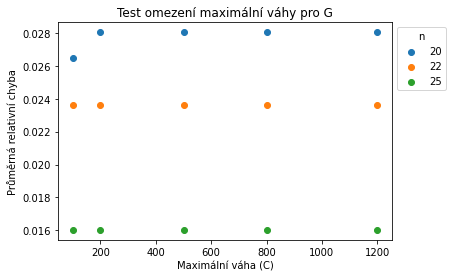

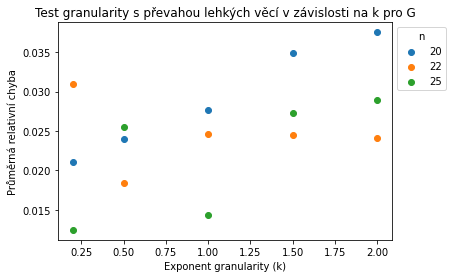

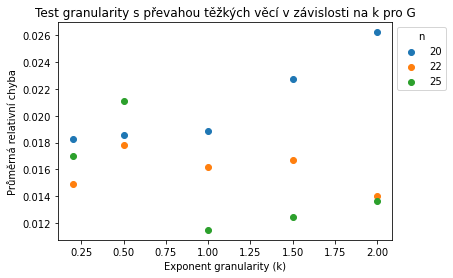

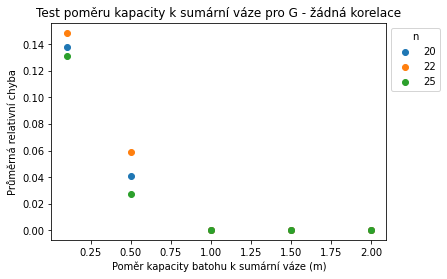

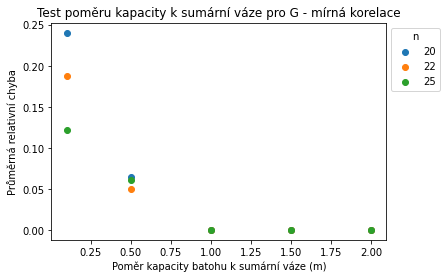

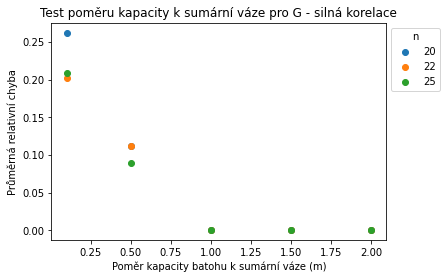

------ Robustnost -------


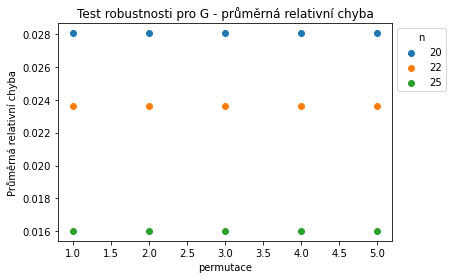

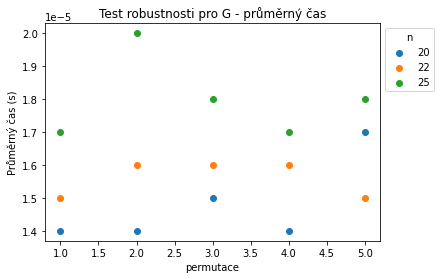

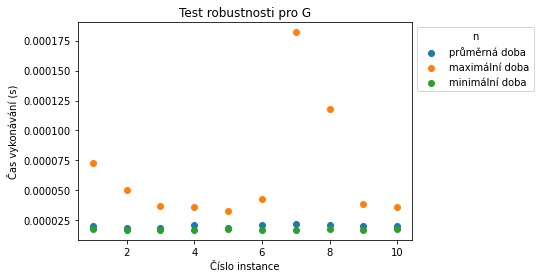

======= R =======


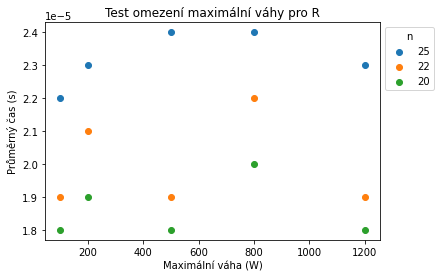

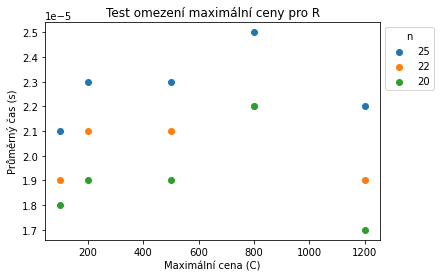

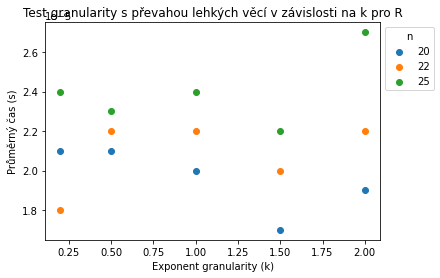

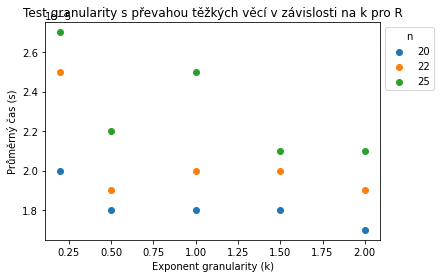

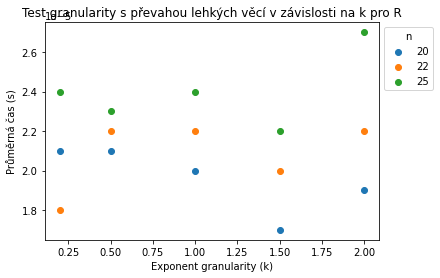

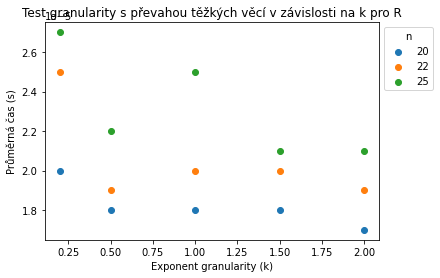

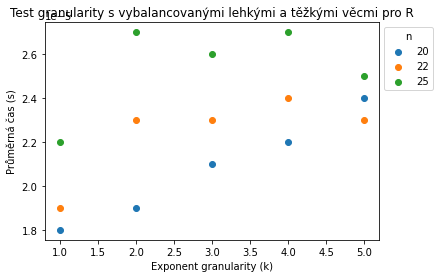

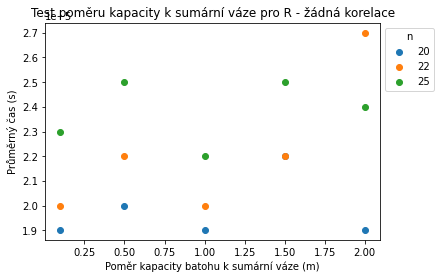

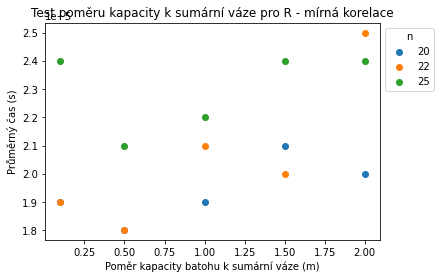

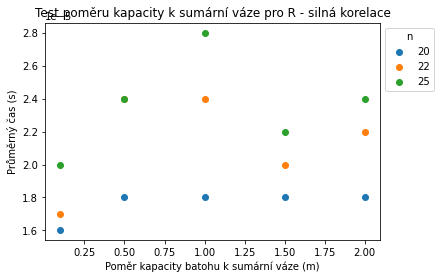

------ Chyby -------


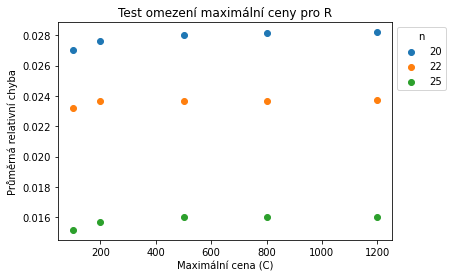

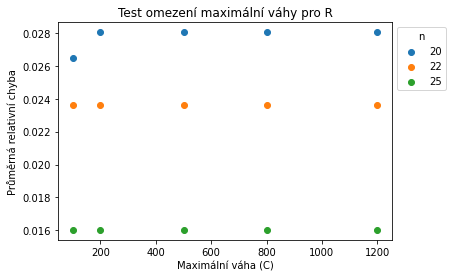

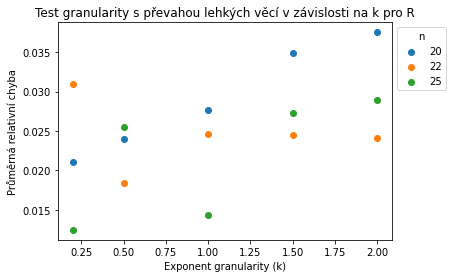

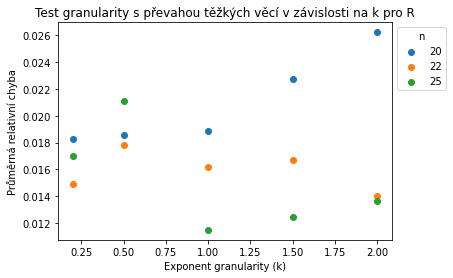

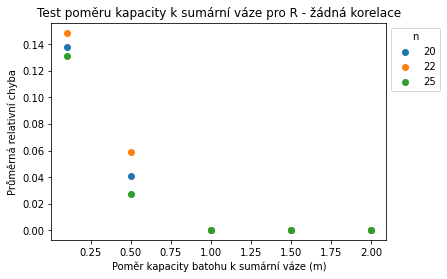

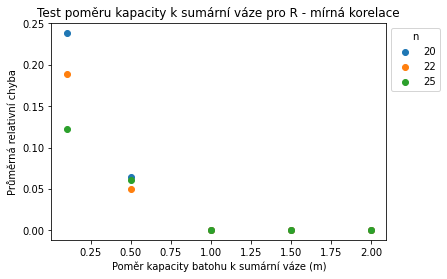

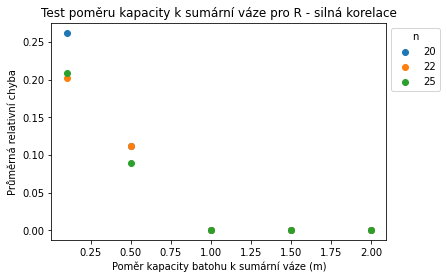

------ Robustnost -------


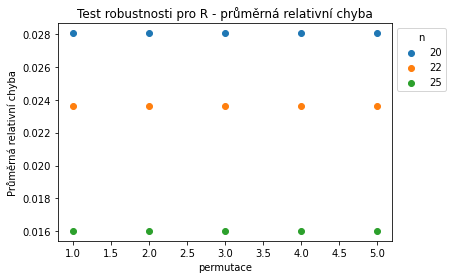

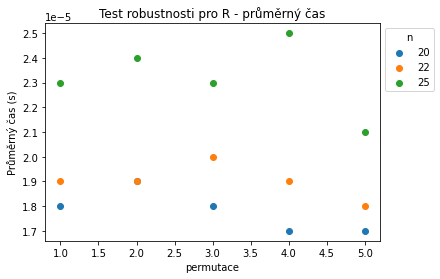

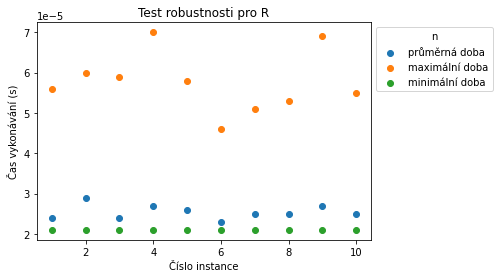

======= DHBP =======


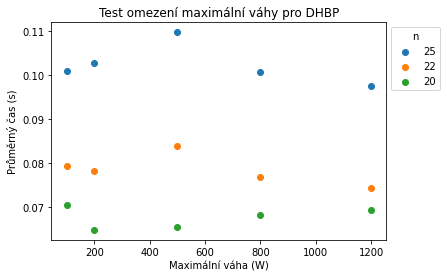

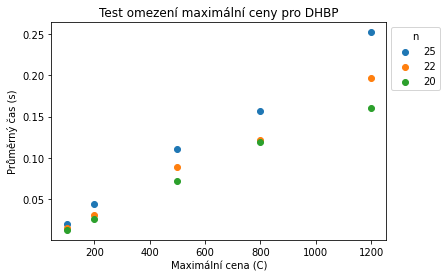

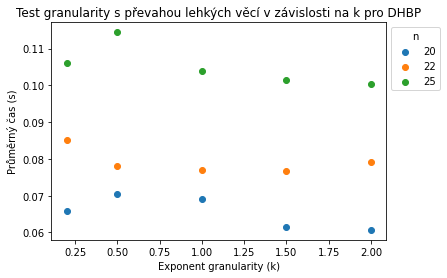

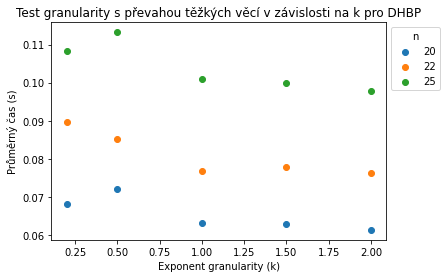

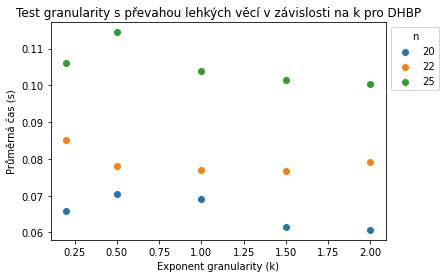

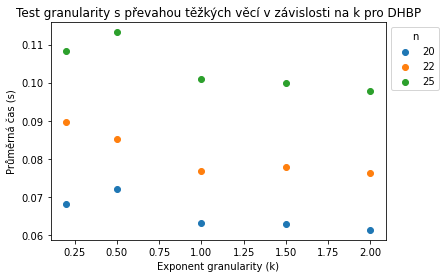

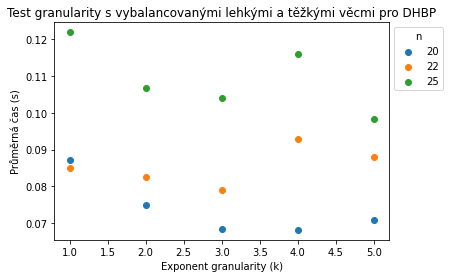

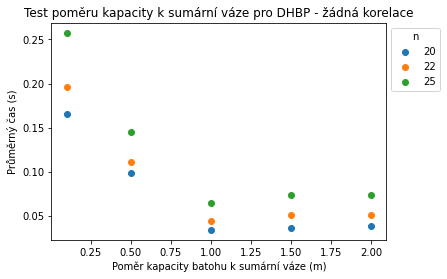

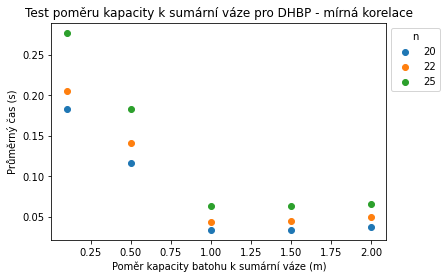

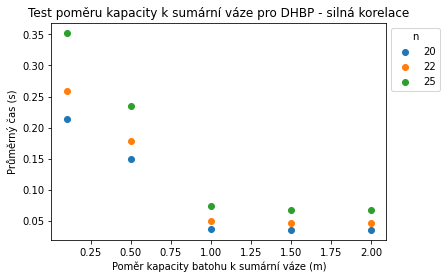

------ Chyby -------


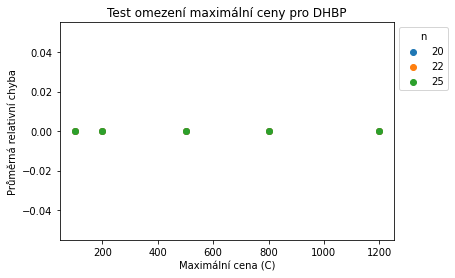

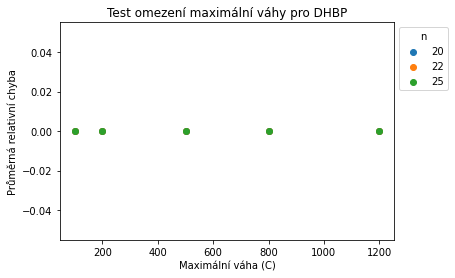

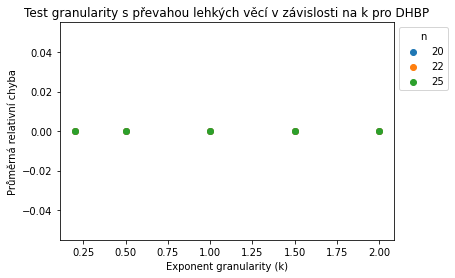

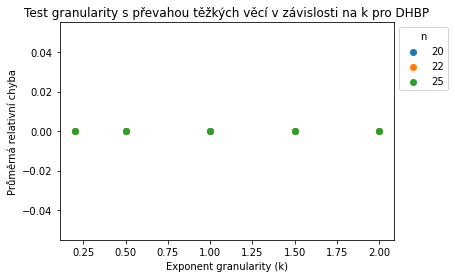

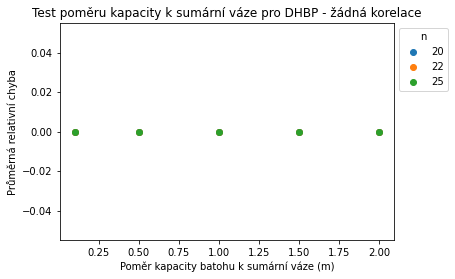

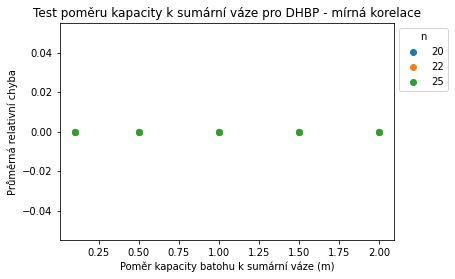

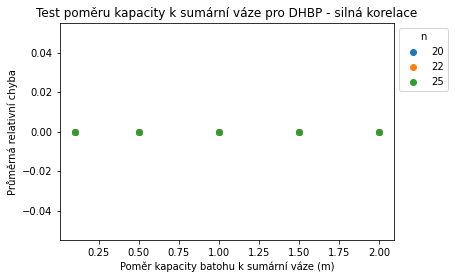

------ Robustnost -------


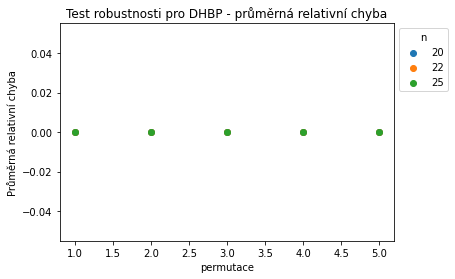

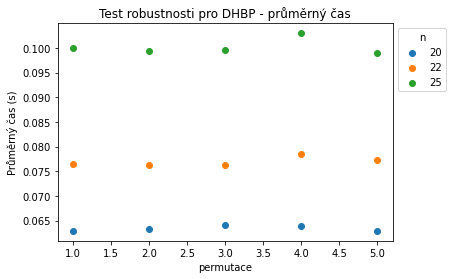

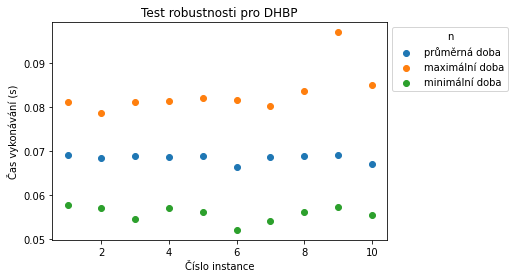

In [48]:
ea = ExpAnalyzer()
ea.analyze()